In [81]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from copy import copy
from tqdm import tqdm

import sustainabilitygame as sg

## Plotting defaults
sns.set_theme(style="ticks", context="notebook")
plt.style.use("dark_background")
cmap = sns.color_palette("viridis", as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Game simulation

In [94]:
# Population properties
N = 46  # population size

# Game properties
R = 50  # number of rounds

# Agent properties
p_action_sus = {"sustainable": 0.8, "exploit": 0.2, "restore": 0.0}
p_action_nonsus = {"sustainable": 0.2, "exploit": 0.8, "restore": 0.0}

# Environment properties
reward_factors = {"sustainable": 0.001, "exploit": 0.002, "restore": 0}
impact_factors = {"sustainable": 0.9995, "exploit": 0.998, "restore": 1.01}

# Simulate game for populations that differ in the ratio of sustainable vs. unsustainable agents
populations = []
p_sus_levels = np.arange(0, 1.01, 0.01)
for p_sus in tqdm(p_sus_levels):
    label = f"p_sus={p_sus:.2f}"
    environment = sg.Environment(
        label=label, reward_factors=reward_factors, impact_factors=impact_factors
    )
    agents = []
    agents.extend(
        [sg.Agent(id=f"s_{i}", p_action=p_action_sus) for i in range(int(N * p_sus))]
    )
    agents.extend(
        [
            sg.Agent(id=f"u_{i}", p_action=p_action_nonsus)
            for i in range(int(N * p_sus), N)
        ]
    )
    population = sg.Population(agents=agents, label=label, environment=environment)
    population.p_sus = p_sus
    for r in range(R):
        population.progress()
    populations.append(population)

100%|█████████████████████████████████████████| 101/101 [00:05<00:00, 17.57it/s]


## Plotting

### Individual Points Histories

Text(0.5, 1.0, 'Individual points histories\nfor Population 50 ($p_{sus} = $0.50)')

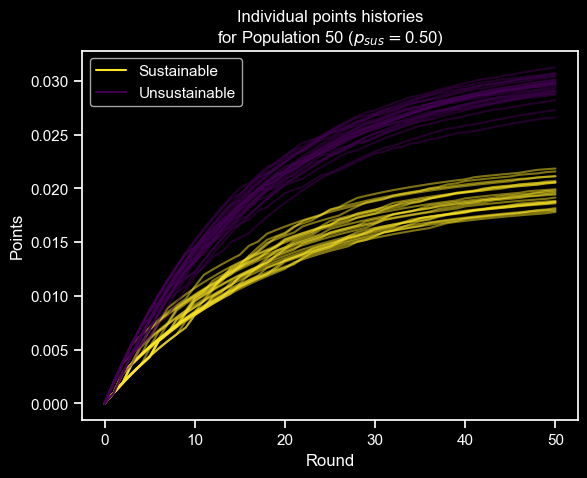

In [100]:
population_index = 50
population = populations[population_index]
fig, ax = plt.subplots(dpi=100)
for agent in population.agents:
    color = cmap(0) if agent.id.startswith("u") else cmap(np.inf)
    alpha = (
        p_sus_levels[population_index]
        if agent.id.startswith("u")
        else 1 - p_sus_levels[population_index]
    )
    ax.plot(agent.points_history, color=color, alpha=alpha)

ax.plot([None], [None], color=cmap(np.inf), label="Sustainable")
ax.plot([None], [None], color=cmap(0), label="Unsustainable")
ax.legend()

ax.set_xlabel("Round")
ax.set_ylabel("Points")
ax.set_title(
    f"Individual points histories\nfor Population {population_index} "
    + r"($p_{sus} = $"
    + f"{p_sus_levels[population_index]:.2f})"
)

### Environmental state

/var/folders/yr/m5569yln71j5rsmfgpcmgy79v2hmms/T/ipykernel_28981/2851000472.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  clb = fig.colorbar(mappable=sm)


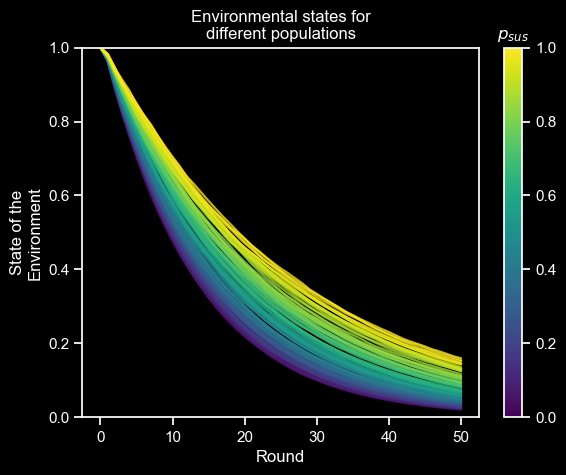

In [96]:
# Plot the environmental state histories
fig, ax = plt.subplots(dpi=100)
for population in populations:
    ax.plot(
        [1]
        + [
            np.mean(population.environment.state_history[r * N : ((r + 1) * N - 1)])
            for r in range(R)
        ],  # For each round, compute mean across participants' actions
        color=cmap(population.p_sus),
        alpha=0.8,
    )

# Labels
ax.set_ylabel("State of the\nEnvironment")
ax.set_xlabel("Round")
ax.set_title("Environmental states for\ndifferent populations")


# Limits
ax.set_ylim(0, 1)

# Add a colorbar
clb = fig.colorbar(mappable=sm)
clb.ax.set_title(r"$p_{sus}$");

Unsustainable populations deplete the environment quicker.

### Total welfare

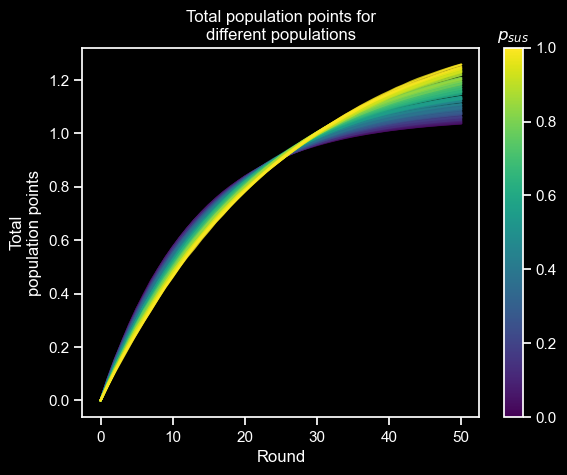

In [97]:
# Plot the population points histories
fig, ax = plt.subplots(dpi=100)
for population in populations:
    ax.plot(population.total_points_history, color=cmap(population.p_sus), alpha=0.8)

# Labels
ax.set_ylabel("Total\npopulation points")
ax.set_xlabel("Round")
ax.set_title("Total population points for\ndifferent populations")

# Add a colorbar
clb = fig.colorbar(mappable=sm, ax=ax)
clb.ax.set_title(r"$p_{sus}$");

Note that unsustainable populations are better of in the short-term (early rounds), but plateau quicker. More sustainable populations can gather points longer, because they have not yet depleted the environment.

### Inequality

#### Gini coefficient $G$

/var/folders/yr/m5569yln71j5rsmfgpcmgy79v2hmms/T/ipykernel_28981/3508706982.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  clb = fig.colorbar(mappable=sm_diverging)


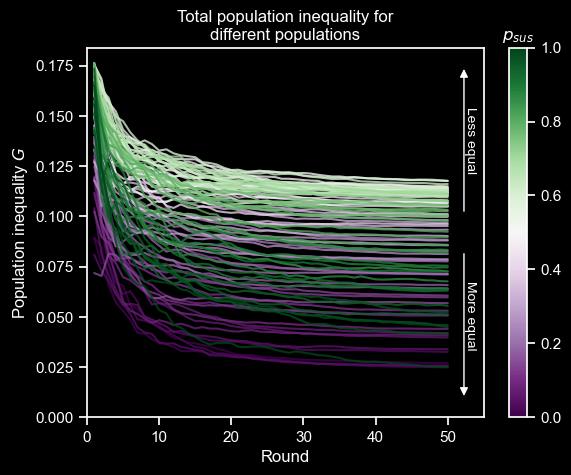

In [101]:
# Plot the population inequalities
cmap_diverging = sns.color_palette("PRGn", as_cmap=True)
sm_diverging = plt.cm.ScalarMappable(cmap=cmap_diverging)

fig, ax = plt.subplots(dpi=100)
for population in populations:
    ax.plot(
        population.gini_coefficient_history,
        color=cmap_diverging(population.p_sus),
        alpha=0.8,
    )

# Labels
ax.set_ylabel(r"Population inequality $G$")
ax.set_xlabel("Round")
ax.set_title("Total population inequality for\ndifferent populations")
ax.set_xlim(0, R * 1.1)
ax.set_ylim(0, None)

# Add Gini explanation
ax.annotate(
    "",
    xy=(0.95, 0.05),
    xycoords="axes fraction",
    xytext=(0.95, 0.45),
    ha="center",
    arrowprops=dict(arrowstyle="-|>", facecolor="white"),
)
ax.annotate(
    "More equal",
    xy=(0.95, 0.05 + 0.45 / 2),
    xycoords="axes fraction",
    rotation=-90,
    ha="left",
    va="center",
    fontsize="small",
)
ax.annotate(
    "",
    xy=(0.95, 0.95),
    xycoords="axes fraction",
    xytext=(0.95, 0.55),
    ha="center",
    arrowprops=dict(arrowstyle="-|>", facecolor="white"),
)
ax.annotate(
    "Less equal",
    xy=(0.95, 0.55 + 0.4 / 2),
    xycoords="axes fraction",
    rotation=-90,
    ha="left",
    va="center",
    fontsize="small",
)

# Add a colorbar
clb = fig.colorbar(mappable=sm_diverging)
clb.ax.set_title(r"$p_{sus}$");

Inequality appears to be lowest in groups with many exploiters, intermediate in groups with many sustainable agents, and highest in mixed groups.

#### Wealthiest and poorest individual

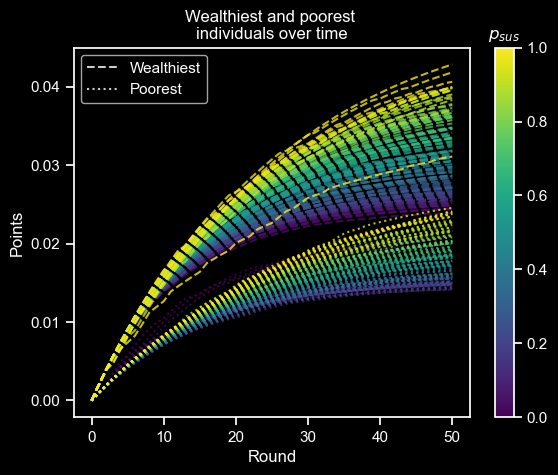

In [99]:
# Plot the population inequalities
fig, ax = plt.subplots(dpi=100)
for population in populations:
    wealth = np.vstack([agent.points_history for agent in population.agents]).T
    wealthy = ax.plot(
        wealth.max(axis=1), ls="dashed", color=cmap(population.p_sus), alpha=0.8
    )
    poor = ax.plot(
        wealth.min(axis=1), ls="dotted", color=cmap(population.p_sus), alpha=0.8
    )

# Legend
w = copy(wealthy[0])
p = copy(poor[0])
w.set_color("white")
p.set_color("white")
ax.legend([w, p], ["Wealthiest", "Poorest"])

# Labels
ax.set_ylabel(r"Points")
ax.set_xlabel("Round")
ax.set_title("Wealthiest and poorest \nindividuals over time")

# Add a colorbar
clb = fig.colorbar(mappable=sm, ax=ax)
clb.ax.set_title(r"$p_{sus}$");

### Points by agent type

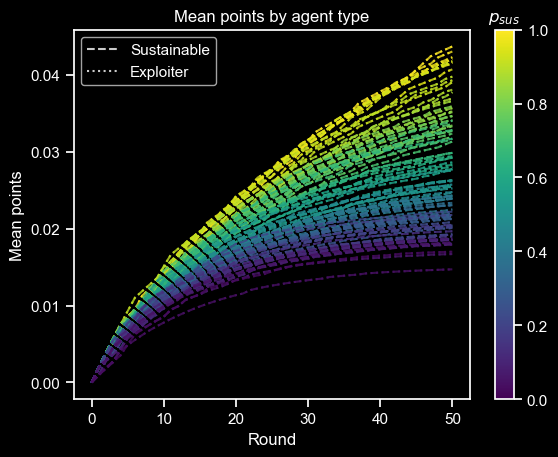

In [80]:
# Plot the population inequalities
fig, ax = plt.subplots(dpi=100)
lines = {}
for population in populations[::-1]:
    for agent_id_stub, linestyle in zip(["s", "u"], ["dashed", "dotted"]):
        try:
            points = np.vstack(
                [
                    agent.points_history
                    for agent in population.agents
                    if agent.id.startswith("s")
                ]
            ).T
            lines[agent_id_stub] = ax.plot(
                points.max(axis=1),
                ls=linestyle,
                color=cmap(population.p_sus),
                alpha=0.8,
            )
        except ValueError:
            continue

# Legend
s = copy(lines["s"][0])
u = copy(lines["u"][0])
s.set_color("white")
u.set_color("white")
ax.legend([s, u], ["Sustainable", "Exploiter"])

# Labels
ax.set_ylabel("Mean points")
ax.set_xlabel("Round")
ax.set_title("Mean points by agent type")

# Add a colorbar
clb = fig.colorbar(mappable=sm, ax=ax)
clb.ax.set_title(r"$p_{sus}$");